**Quantum Variational Encoder**

1.   Install and import required package

In [ ]:
!pip install qiskit
!pip install qiskit-terra
!pip install qiskit-machine-learning
!pip install pylatexenc
!pip install sympy==1.6
!pip install qiskit-aer-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512586 sha256=a76e9d97478d33fbeb13d474f16a5aa2ec80513b6cfb3ba99

In [ ]:
import json
import time
import warnings
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from skimage.transform import rotate
from skimage import io
import cv2 as cv
#from keras.preprocessing.image import ImageDataGenerator
from tifffile import imread
from IPython.display import clear_output

from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = np.random.randint(1000, size=1)
print("seed:"+str(algorithm_globals.random_seed))

seed:[873]


<ipython-input-2-9b28552d55bb>:22: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA
<ipython-input-2-9b28552d55bb>:29: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = np.random.randint(1000, size=1)
<ipyt

2. Downloading and reading dataset


upload kaggle.json for the api key to fetch dataset directly from kaggle


In [ ]:
from google.colab import files
files.upload()
#2. Series of commands to set-up for download

!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

#3. giving rw access (if 401-nathorized)

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Jan 27 11:35 kaggle.json
/content


Download and unzip dataset

dataset choice 1 : histopathologic cancer dataset

In [ ]:
#!kaggle datasets download -d competitions/histopathologic-cancer-detection
!mkdir -p /content/histopathologic-cancer
!kaggle competitions download -c histopathologic-cancer-detection
!unzip -qq /content/histopathologic-cancer-detection.zip -d /content/histopathologic-cancer

100% 6.31G/6.31G [05:41<00:00, 18.1MB/s]
100% 6.31G/6.31G [05:41<00:00, 19.8MB/s]


dataset choice 2 : blood dataset

In [ ]:
!mkdir -p /content/blood-cancer
!kaggle datasets download -d andrewmvd/leukemia-classification
!unzip -qq /content/leukemia-classification.zip -d /content/blood-cancer

dataset choice 3 : skin cancer dataset

In [ ]:
!mkdir -p /content/skin-cancer
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -qq /content/skin-cancer-mnist-ham10000.zip -d /content/skin-cancer

In [ ]:
#if using histopathology dataset
test_path = '../content/histopathologic-cancer/test/'
train_path = '../content/histopathologic-cancer/train/'


train_data = pd.read_csv('../content/histopathologic-cancer/train_labels.csv')
images_train=train_data
images_train["label"] = train_data["label"]
images_train["id"] = train_data["id"]+".tif"

Definiton of matplot figure to illustrate dataset

In [ ]:
def plotter(train,hist):
    if hist=='1':

        sns.countplot(x=train['label'], palette='colorblind').set(title='Label and Counts');
        fig = px.pie(train_data,
             values = train_data['label'].value_counts().values,
             names = train_data['label'].unique())
        fig.update_layout(
            title={
                'text': "Label Percentage Pie Chart",

                'xanchor': 'center',
                'yanchor': 'top'})
        fig.show()

   Label Counts
0        130908
1         89117


<ipython-input-26-6e41011254cd>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




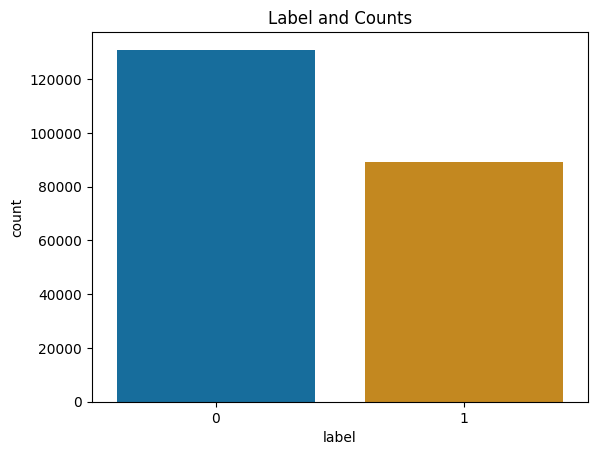

In [ ]:
print(pd.DataFrame(data={'Label Counts': train_data['label'].value_counts()}))
plotter(train_data,hist='1')

Read the image to training array, one array for each channel

In [ ]:
rows,cols = 20,20


#fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
imtrains = []
imtrains_r = []
imtrains_g = []
imtrains_b = []
for i in range(20 * 20):
    image = imread(train_path + images_train['id'][i])
    image = tf.image.resize(image,(32,32),method='nearest').numpy()
    ra = image[:,:,0]
    ga = image[:,:,1]
    ba = image[:,:,2]
    #gray = (0.299*ra + 0.587*ga + 0.114*ba)
    #imtrains.append(image)
    imtrains_r.append(ra)
    imtrains_g.append(ga)
    imtrains_b.append(ba)

3. Defining quantum auntoencoder circuit

definition of ansatz

In [ ]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=10)

circuit draw testing

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


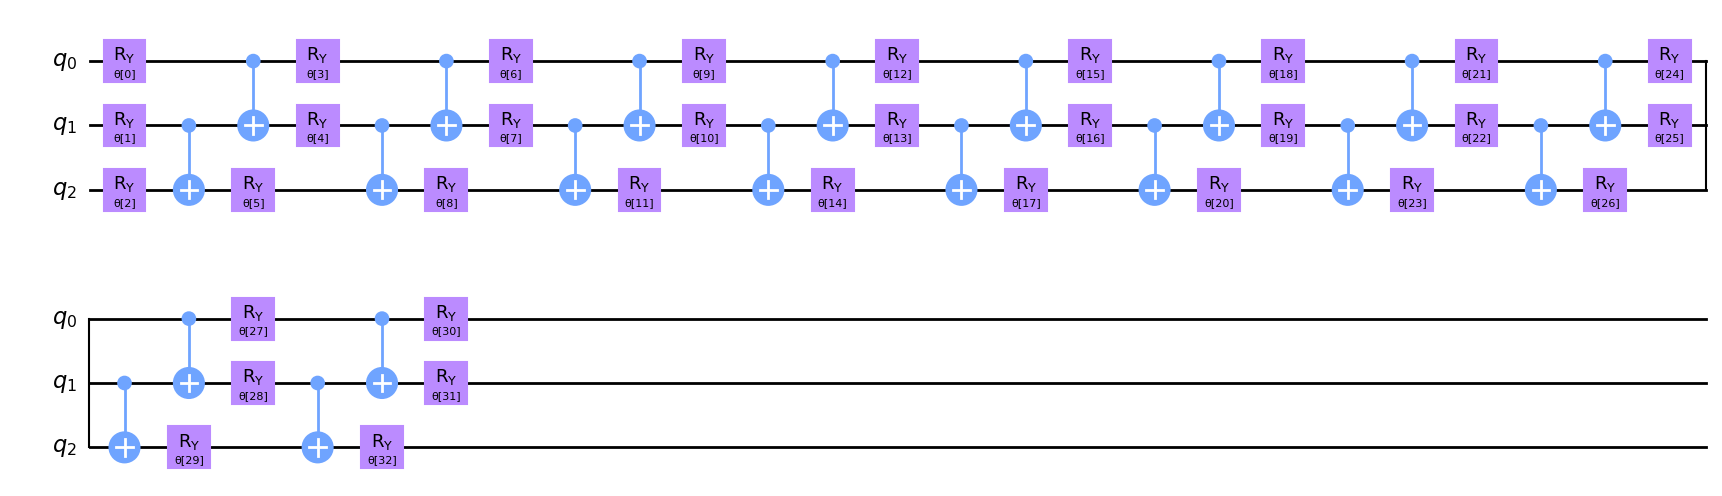

In [ ]:
num_qubits = 3
circ = ansatz(num_qubits)
circ.decompose().draw("mpl")

Constructor for quantum circuit
input :
1.   Number of latent qubit
2.   Number of trash qubit



In [ ]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit


VAE circuit to reduce 32x32 image feature



/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


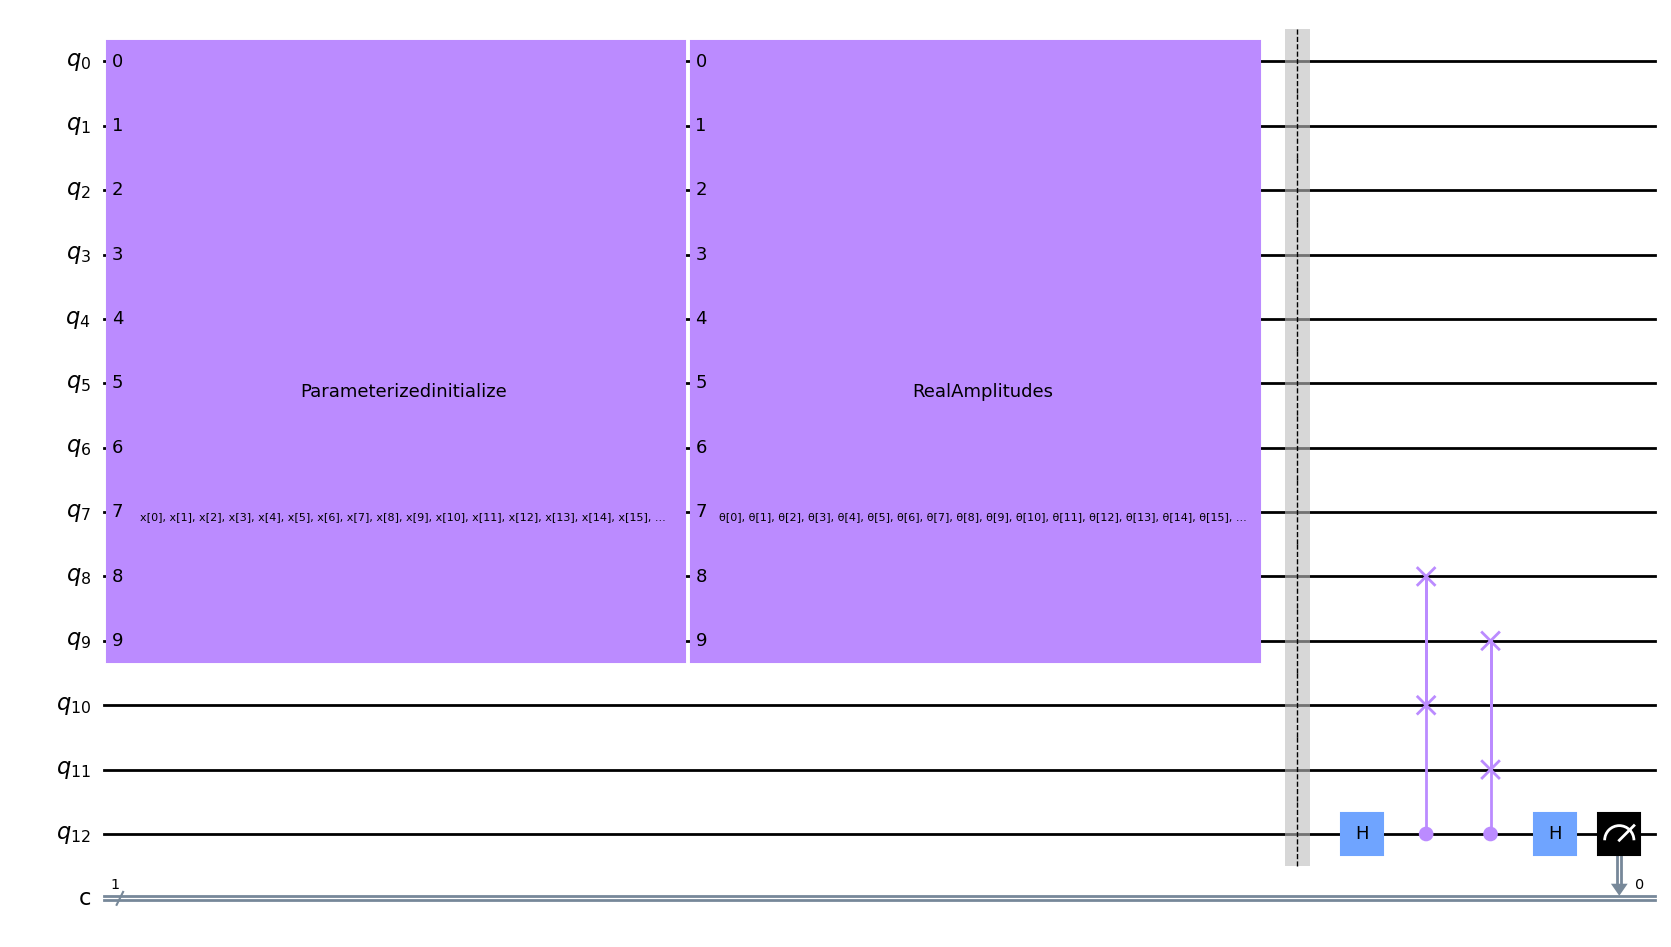

In [ ]:
num_latent = 8
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc_can = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc_can = qc_can.compose(fm, range(num_latent + num_trash))
qc_can = qc_can.compose(ae)

qc_can.draw("mpl")

reshape 2d image to 1d array in batch with a size of 400 for each batch

In [ ]:
imtrains_r = np.array(imtrains_r)
imtrains_g = np.array(imtrains_g)
imtrains_b = np.array(imtrains_b)

print(imtrains_r.shape)
imtrains_r = imtrains_r.reshape(400,1024)
imtrains_g = imtrains_g.reshape(400,1024)
imtrains_b = imtrains_b.reshape(400,1024)

(400, 32, 32)


normalize pixel value in image

In [ ]:
import cmath
#Funtion to normalize the data of an array
'''
Input = Array with n values
Output = Array with normalized valued
'''
imtrains_norm=[]
def Normalize(row):
    #We calculate the squareroot of the sum of the square values of the row
    suma = np.sqrt(np.sum(row**2))
    if suma == 0.:
        #If the sum is zero we return a 0
        return 0.0
    #Else we divide each value between the sum value above
    row = row/suma
    return row

#Normalize the training set data
for i in range(len(imtrains_r)):
    imtrains_norm.append(Normalize(imtrains_r[i]))

In [ ]:
from qiskit_aer import AerError
from qiskit import QuantumCircuit
from qiskit import Aer, transpile


try:
    simulator_gpu = Aer.get_backend('aer_simulator')
    simulator_gpu.set_options(device='GPU')
except AerError as e:
    print(e)


from qiskit.primitives import Sampler

sampler_gpu = Sampler()
sampler_gpu.set_options(backend=simulator_gpu, device='GPU')
sampler_gpu.options

Options(backend=AerSimulator('aer_simulator'), device='GPU')

In [ ]:
def identity_interpret(x):
    return x


qnn_can = SamplerQNN(
    circuit=qc_can,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)



In [ ]:
def cost_func_can_r(params_values):
    probabilities = qnn_can.forward(imtrains_r, params_values)
    cost = np.sum(probabilities[:, 1]) / imtrains_r.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

def cost_func_can_g(params_values):
    probabilities = qnn_can.forward(imtrains_g, params_values)
    cost = np.sum(probabilities[:, 1]) / imtrains_g.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

def cost_func_can_b(params_values):
    probabilities = qnn_can.forward(imtrains_b, params_values)
    cost = np.sum(probabilities[:, 1]) / imtrains_b.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

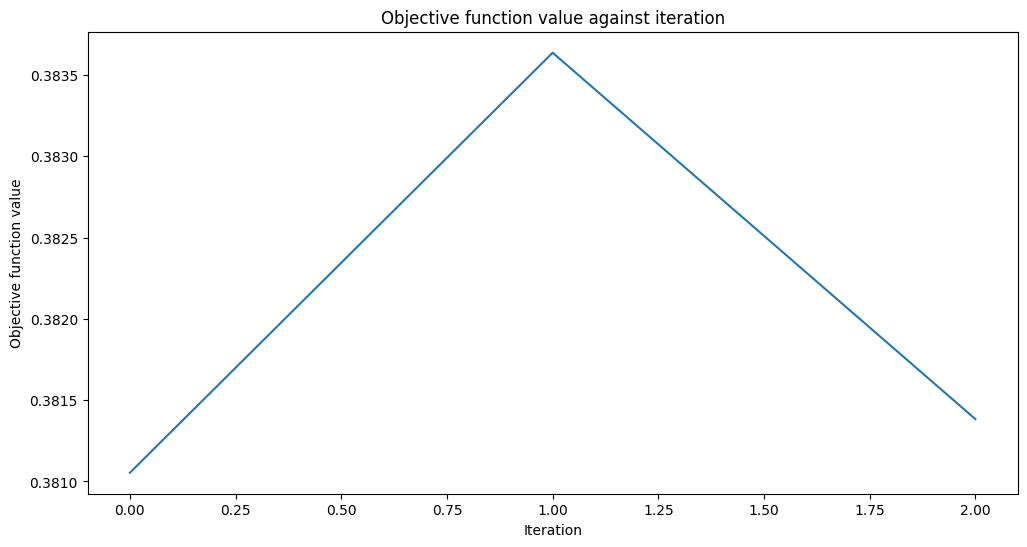

Fit in 374.91 seconds


In [ ]:
opt = COBYLA(maxiter=3)
initial_point = algorithm_globals.random.random(ae.num_parameters)
print(len(initial_point))

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_can_r,x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

Decode the compressed image and see the result

In [ ]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images

image_test = imread(train_path + images_train['id'][0])
image_test = tf.image.resize(image,(32,32),method='nearest').numpy()
ra_test = image[:,:,0]
for image in ra:
    original_qc = fm.assign_parameters(image_test)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 4))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 4))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()

ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

Evaluate the fidelity

In [ ]:
vae_state = Statevector(qc_can).data
output_state = Statevector(test_qc).data

fidelity = np.sqrt(np.dot(vae_state.conj(), output_state) ** 2)
print("Fidelity score: ", fidelity.real)

QiskitError: 'Cannot define a ParameterizedInitialize with unbound parameters'